# Проект Определение возраста покупателей

# Исследовательский анализ данных

## Обзор данных и исследовательский анализ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import warnings 
warnings.filterwarnings('ignore') #скроем предупреждения

В папке `/datasets/faces` содержится папка со всеми изображениями `final_files` и csv-файл labels.csv с указанием возраста людей с фотографий. 

In [2]:
# чтение файла `labels.csv` и сохранение в переменной `df`
df = pd.read_csv('labels.csv')

In [3]:
# просмотр 5 случайных строк таблицы `df`
df.sample(5)

,Unnamed: 0,file_name,real_age
3390,3390,003390.jpg,43
928,928,000928.jpg,50
2630,2630,002630.jpg,7
657,657,000657.jpg,16
4082,4082,004082.jpg,37


In [4]:
# получение общей информации о таблице `df`
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7591 non-null   int64 
 1   file_name   7591 non-null   object
 2   real_age    7591 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.0+ KB


В таблице 2 столбца. Типы данных в столбцах: object и int64.

Согласно документации к данным:
* `file_name` — содержит название файла с фотографией человека;
* `real_age` — реальный возраст этого человека.

Целевой признак - `real_age`.

Названия столбцов соответствуют хорошему стилю.

Количество значений в столбцах одинаковое, значит, пропущенных значений нет.

In [5]:
# # получение общей информации о значениях столбца `real_age`
df.describe()

,Unnamed: 0,real_age
count,7591.00000,7591.000000
mean,3795.00000,31.201159
std,2191.47728,17.145060
min,0.00000,1.000000
25%,1897.50000,20.000000
50%,3795.00000,29.000000
75%,5692.50000,41.000000
max,7590.00000,100.000000


Всего в таблице 7591 объект, минимальный возраст - 1 год, максимальный - 100 лет, средний возраст людей в выборке - 31 год, медиана возраста - 29.

Построим график распределения возраста в выборке.

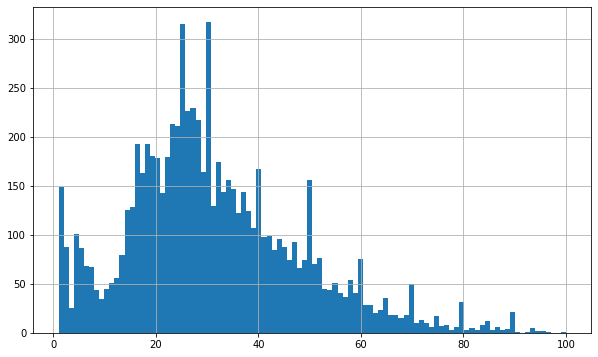

In [6]:
fig = plt.figure(figsize=(10,6))
plt.grid(visible=True)
plt.hist(df['real_age'], bins=100)
plt.show();

Распределение стремится к нормальному, наибольшее количество значений возраста людей в выборке - 23-30 лет. Видны пики в 25-30-40-50-60-70-80-90 лет, похоже это последствия округления в процессе разметки. Также есть провалы в возрастах 3, 9 и 31 год.

Из фотографий в папке сформируем батчи с изображениями и метками возрастов при помощи класса ImageDataGenerator.

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Извлечём данные из папки 
datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


В папке 7591 изображение, что соответствует количеству значений объектов в таблице с указанием возраста людей. Учитывая, что для решения задачи мы будем использовать архитектуру ResNet50, а в этой сети изначально количество параметров порядка 23 млн, нам потребуется провести аугментацию датасета с целью снижения переобучения модели.

In [9]:
features, target = next(datagen_flow)

features.shape

(32, 224, 224, 3)

Получили признаки — четырёхмерный тензор, в котором 32 изображения размером 150x150 с тремя цветовыми каналами. Выведем 12 изображений из датасета.

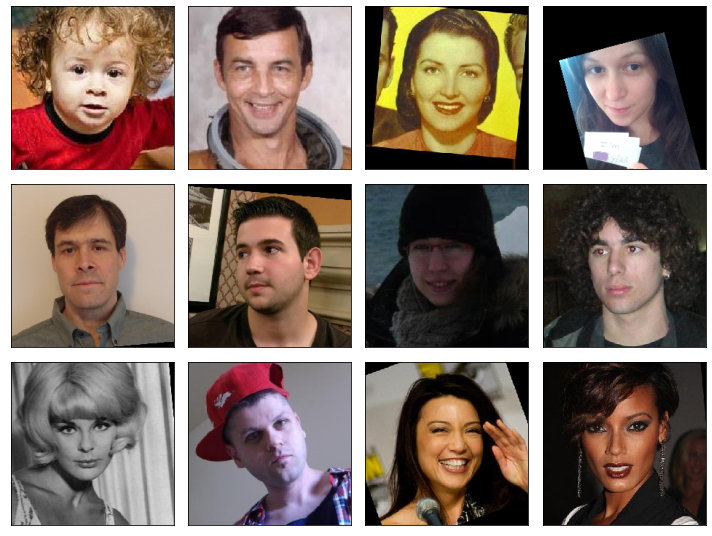

In [10]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На фотографиях представлены лица людей разных возрастов и разной рассовой и гендерной пренадлежности. В датасете содержатся как цветные, так и черно-белые изображения. Положние изображений на фотографиях также разное, некоторые из них находятся под углом, имеются чёрные области около рамки из-за выравнивания фотографий под общий размер, чтобы улучшить качество модели также проведём аугментацию снимков. Также можно отметить, что фотографии сделаны в разные года 20-21 вв.

In [11]:
# выведем соответствующий им возраст
target[:12]

array([ 1, 46, 35, 23, 47, 26, 20, 17, 25, 27, 47, 26])

Предположительно значение в таргетах соответствует изображениям на фотографиях.

### Выводы

Датасет состоит из папки с фотографиями разных людей разных возрастов и времени создания фотографий, а также из файла с указанием реальных возрастов людей с фотографий.

В каждой строке таблицы с указанием возраста содержится название файла с изображением и указанием возраста человека с фотографии. 

Предварительно можно утверждать, что, данных достаточно для построения нейронной сети. Пропусков в данных не обнаружено, название столбцов соответствует хорошему стилю, количество изображений соответствует количеству строк в таблице с возрастом людей. По фрагменту датасета можно сделать вывод, что изображения на фотографиях соответствуют данным о возрасте в таблице с целевым признаком.

Исходя из анализа распределения возраста в выборке можно сделать вывод о том, что модель научится лучше определять вораст людей от 20 до 30 лет, так как их большинство. Это необходимо иметь ввиду при соотношении результатов работы модели с реальной целевой аудиторией сети супермаркетов «Хлеб-Соль». В случае, если распределение возрастов клиентов данной сети сильно расходится с распределением в датасете, необходимо либо скорректировать возрастной состав датасета для обучения, либо изменить веса значимости определённых возрастов клиентов в обучающей выборке. Необходимо согласовать подход с представителями сети супермаркетов.

Чтобы двигаться дальше, нужно подготовить данные для обучения нейронной сети.

## Подготовка данных к обучению

Наш целевой признак `real_age` (реальный возраст людей с фотографий) - является количественным, поэтому мы будем решать задачу регрессии. 

Для решения задачи применим нейронную сеть ResNet50, предобученной на датасете ImageNet. Для решения нашей задачи потребуется всего один нейрон, который вернёт число-предсказание, слой с 1000 нейронов следует удалить из сети.

Используем в качестве функции активации ReLU, так как положительные прогнозы сети она не меняет, а все отрицательные — приводит к нулю. Чисел меньше 0 у нас быть не может. А вкачестве функции потерь - MSE, так как зачастую нейронные сети с данной функцией обучаются быстрее.

Метрика качества модели по условию задачи MAE, необходимо добиться значения метрики на тестовой выборке не больше 8.

Создадим функцию загрузки обучающей выборки, применим отражение по вертикали и сдвиги изображений по вертикали и горизонтали на 20% от исходного размера.

In [7]:
def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)
    
    return train_datagen_flow

Создадим функцию загрузки тестовой выборки.

In [8]:
def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    
    validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)
    
    return val_datagen_flow

### Выводы

На данном этапе мы разделили датасет на обучающую и тестовую выборки, используя загрузчик данных.

## Обучение нейронной сети и рассчёт её качества

Напишем функцию для создания модели.

In [9]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    optimizer = Adam(lr=0.0001)
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

Напишем функцию для тренировки модели.

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Результат вывода модели после запуска в отдельном GPU-тренажёре:

Train for 356 steps, validate for 119 steps

Epoch 1/15
356/356 - 98s - loss: 261.7325 - mae: 11.8833 - val_loss: 315.5901 - val_mae: 13.1801

Epoch 2/15
356/356 - 90s - loss: 123.4861 - mae: 8.4496 - val_loss: 143.3787 - val_mae: 9.3006

Epoch 3/15
356/356 - 90s - loss: 101.9656 - mae: 7.6618 - val_loss: 123.1739 - val_mae: 8.3387

Epoch 4/15
356/356 - 90s - loss: 84.4200 - mae: 7.0141 - val_loss: 117.6764 - val_mae: 8.2983

Epoch 5/15
356/356 - 90s - loss: 71.4755 - mae: 6.4738 - val_loss: 117.6908 - val_mae: 8.5111

Epoch 6/15
356/356 - 90s - loss: 65.1829 - mae: 6.1753 - val_loss: 97.2821 - val_mae: 7.2848

Epoch 7/15
356/356 - 90s - loss: 56.4381 - mae: 5.7299 - val_loss: 107.4309 - val_mae: 7.7760

Epoch 8/15
356/356 - 90s - loss: 50.1131 - mae: 5.4122 - val_loss: 81.1431 - val_mae: 6.8047

Epoch 9/15
356/356 - 90s - loss: 44.3848 - mae: 5.1281 - val_loss: 118.6769 - val_mae: 8.0992

Epoch 10/15
356/356 - 90s - loss: 42.2714 - mae: 5.0195 - val_loss: 96.9835 - val_mae: 7.4563

Epoch 11/15
356/356 - 90s - loss: 36.8279 - mae: 4.6928 - val_loss: 88.0489 - val_mae: 6.9454

Epoch 12/15
356/356 - 90s - loss: 34.9835 - mae: 4.5294 - val_loss: 255.5438 - val_mae: 12.6434

Epoch 13/15
356/356 - 90s - loss: 30.6275 - mae: 4.2679 - val_loss: 83.4675 - val_mae: 6.7667

Epoch 14/15
356/356 - 90s - loss: 29.9094 - mae: 4.2183 - val_loss: 85.3124 - val_mae: 6.8072

Epoch 15/15
356/356 - 89s - loss: 28.9895 - mae: 4.1600 - val_loss: 88.0497 - val_mae: 7.1363
119/119 - 9s - loss: 88.0497 - mae: 7.1363

Test MAE: 7.1363

### Выводы

На данном этапе мы подобрали архитектуру нейронной сети, MAE на тестовой выборке 7.38, что удовлетворяет условиям задачи.

## Анализ обученной модели

Мы использовали следующие подходы для создания и обучения модели:
* применили архитектуру ResNet50 (50 = количество слоёв в сети), при этом слой с 1000 нейронов мы удалили из сети, так как нам нужен всего один нейрон, который вернёт число-предсказание = возраст клиента;
* чтобы адаптировать ResNet50 к нашей задаче, мы убрали верхушку и сконструировали её заново, в backbone задали include_top=False;
* для решения задачи мы загрузили предобученные веса модели ResNet50, чтобы код выполнялся быстрее, веса загружались с сервера (`/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5`);
* итоговые параметры обучения:
    - размер батча = 16;
    - в качестве оптимизатора использовался алгоритм Adam, с learning rate = 0.0001
    - заморозка весов бэкбона не использовалась, так как изображений в даасете достаточно с учётом проведённой аугментации;
    - количество эпох = 15;
    - использованы следующие аугментации: отражение по вертикали, сдвиги изображений по вертикали и горизонтали на 20% от исходного размера;
* в качестве функции активации мы использовали ReLU, так как положительные прогнозы сети она не меняет, а все отрицательные — приводит к нулю, чисел меньше 0 у нас быть не может; а в качестве функции потерь - MSE, так как зачастую нейронные сети с данной функцией обучаются быстрее;
* по итогам работы нейронной сети можно увидеть, что модель переобучается, однако для нейронных сетей это является нормой, требуемое значение метрики MAE на тестовой выборке при этом достигнуто = 7.1363 (при требуемом не больше 8).

## Общий вывод

Исследование проводилось в четыре этапа:

* На этапе Обзор данных и исследовательский анализ мы ознакомились с данными в предоставленном датасете и зафиксировали, что предварительно данных для проведения исследования достаточно; при этом, исходя из анализа распределения возраста в выборке можно сделать вывод о том, что модель научится лучше определять вораст людей от 20 до 30 лет, так как их большинство. Это необходимо иметь ввиду при соотношении результатов работы модели с реальной целевой аудиторией сети супермаркетов «Хлеб-Соль». В случае, если распределение возрастов клиентов данной сети сильно расходится с распределением в датасете, необходимо либо скорректировать возрастной состав датасета для обучения, либо изменить веса значимости определённых возрастов клиентов в обучающей выборке. Необходимо согласовать подход с представителями сети супермаркетов;
* На этапе Подготовка данных мы разделили датасет на обучающую и тестовую выборки, используя загрузчик данных;
* На этапе Обучение нейронной сети и рассчёт её качества мы разработали архитектуру нейронной сети, обучили её, получили предсказания по обучающей и тестовой выборкам и рассчитали значение метрики MAE для каждой из выборок;
* На этапе Анализ обученной модели мы описали испольльзуемые для создания и обучения модели подходы.

Исходя из полученных результатов для решения задачи определения возраста по фотографии клиентов сетевого супермаркета «Хлеб-Соль»  предлагается выбрать нейронную сеть ResNet50 с предложенной архитектурой, так как значение MAE на тестовой выборке удовлетворяет условиям проекта (=7.14).